In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad

from binarypredictor.datagen import PolyGenerator
from binarypredictor.poly import Polynomial, PolynomialSet
from binarypredictor.net import DerivativeNet

In [2]:
pg = PolyGenerator(4)
pg.add_constraint(0.5, 1, 0)
pg.add_constraint(0.1, 0, 1)
pg.add_constraint(0.8, 0, 1)
pg.add_constraint(0.5, 0, 2)
pg.add_constraint(0.9, 0, 5)
#pg.add_constraint(0.2, 0, 2.5)

qg = PolyGenerator(4)
qg.add_constraint(0.5, 1, 0)
qg.add_constraint(0.1, 0, 2)
qg.add_constraint(0.5, 0, -.2)
qg.add_constraint(0.9, 1, -6)
qg.add_constraint(0.9, 0, 8)
#qg.add_constraint(0.2, 0, 1.5)

In [3]:
x = torch.arange(0., 1.0, step=0.01)

poly_set = PolynomialSet() 
poly_set.append(Polynomial(pg.get_cfs())) 
poly_set.append(Polynomial(qg.get_cfs()))

d_poly_set = poly_set.get_derivatives()

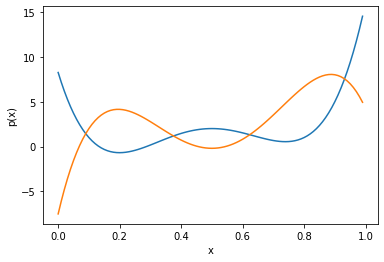

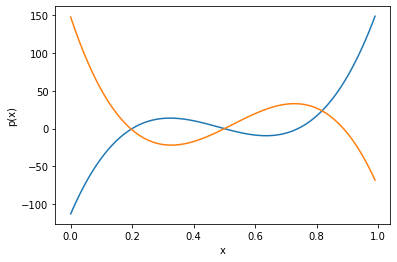

In [4]:
poly_set.plot(x)
plt.show()

d_poly_set.plot(x)
plt.show()

In [36]:
out_features = 1000
net = DerivativeNet(train=True, in_features=200, hidden_size_linear=256, out_features=out_features, hidden_layers=1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [37]:
x_in = torch.arange(0., 1.0, step=0.01)
x = torch.arange(0., 1., step=1/out_features)

for i in range(10000):
    inp = poly_set.get_values(x_in, 'v')
    out = net(inp.squeeze().float())
    
    x_range = torch.vstack((out, x)).T
    p_vals = poly_set.get_values(x_range)
    dp_vals = d_poly_set.get_values(x_range)
        
    optimizer.zero_grad()
    loss = nn.MSELoss()(p_vals[:,0] - out * dp_vals[:, 0], p_vals[:,1] - x * dp_vals[:, 1])
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if i % 250 == 0:
        print(loss)

tensor(1.2696e+10, grad_fn=<MseLossBackward0>)
tensor(85648.0391, grad_fn=<MseLossBackward0>)
tensor(24322.8965, grad_fn=<MseLossBackward0>)
tensor(11098.2900, grad_fn=<MseLossBackward0>)
tensor(6212.0869, grad_fn=<MseLossBackward0>)
tensor(3907.3757, grad_fn=<MseLossBackward0>)
tensor(2654.2764, grad_fn=<MseLossBackward0>)
tensor(1906.0833, grad_fn=<MseLossBackward0>)
tensor(1428.3441, grad_fn=<MseLossBackward0>)
tensor(1108.2357, grad_fn=<MseLossBackward0>)
tensor(885.8323, grad_fn=<MseLossBackward0>)
tensor(726.1786, grad_fn=<MseLossBackward0>)
tensor(608.8314, grad_fn=<MseLossBackward0>)
tensor(520.7990, grad_fn=<MseLossBackward0>)
tensor(453.6118, grad_fn=<MseLossBackward0>)
tensor(401.7412, grad_fn=<MseLossBackward0>)
tensor(361.0267, grad_fn=<MseLossBackward0>)
tensor(328.7153, grad_fn=<MseLossBackward0>)
tensor(302.9612, grad_fn=<MseLossBackward0>)
tensor(305.8322, grad_fn=<MseLossBackward0>)
tensor(265.9651, grad_fn=<MseLossBackward0>)
tensor(252.5979, grad_fn=<MseLossBackward

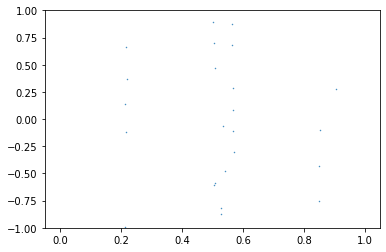

In [73]:
out = (net(inp.squeeze().float()))
x = torch.arange(0., 1., step=1/out_features)

x_range = torch.vstack((out, x)).T
dp_vals = d_poly_set.get_values(x_range)

plt.scatter(x, (dp_vals[:, 0] - dp_vals[:, 1]).detach(), s=0.2)
plt.ylim(-1, 1)
plt.show()

#close = (dp_vals[:, 0] - dp_vals[:, 1] < 1e-1) & (dp_vals[:, 0] - dp_vals[:, 1] > -1e-1)

dp_vals_ = dp_vals[close]
out_ = out#[close]
x_ = x#[close]

valid_idx = torch.where((out_ >= 0) & (out_ <= 1))
out_ = out_[valid_idx]
x_ = x_[valid_idx]

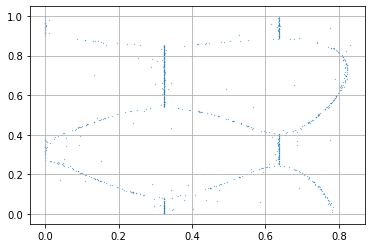

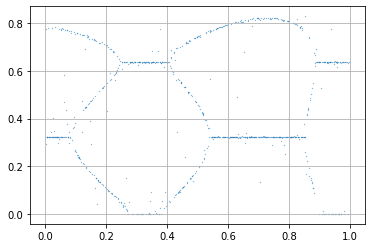

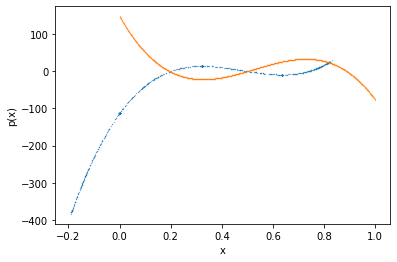

In [67]:
plt.scatter(out_.detach().numpy(), x_, s=.05)
plt.grid()
plt.show()

plt.scatter(x_, out_.detach().numpy(), s=.05)
plt.grid()
plt.show()

x_range_ = torch.vstack((out_, x_)).T
d_poly_set.plot(x_range, scatter=True)

plt.show()

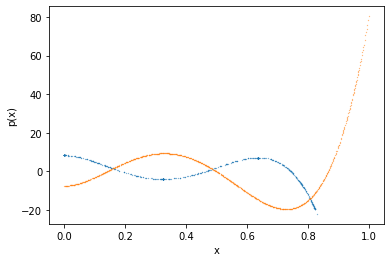

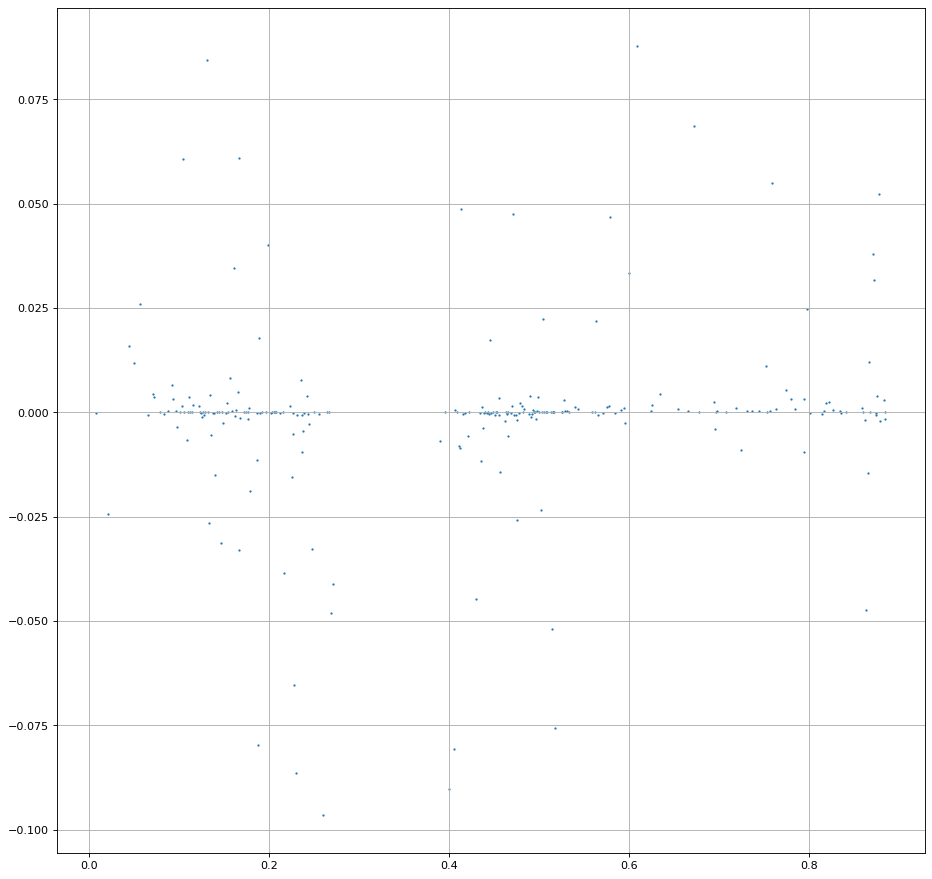

In [68]:
eqns = poly_set.get_values(x_range_) - x_range_ * d_poly_set.get_values(x_range_)
eqn_poly_set = PolynomialSet()
eqn_poly_set.from_values(x_range_, eqns)
eqn_poly_set.plot(x_range_, scatter=True)
plt.show()

diff = eqn_poly_set.diff(x_range_, [0, 1])
idx_ = torch.where(abs(diff) < 1e-1)[0]
x__ = x_[idx_]
diff_ = diff[idx_]
#sign_diff = torch.diff(torch.sign(diff))
#idx = (torch.where(sign_diff != 0)[0] + 1)
    
plt.figure(figsize=(14, 14), dpi=80)
#plt.ylim(-1, 1)
plt.scatter(x__, diff_.detach(), s=1)
plt.grid()
plt.show()

In [43]:
if len(idx) > 0:
    #splits = tuple(torch.where(torch.diff(idx) > 1)[0] + 1)
    #idx_split = torch.tensor_split(idx, splits)
    
    #roots = []

    #for i in idx_split:
    #    i_min = torch.abs(eqn[i]).argmin()
    #    roots.append(i[i_min].item())

    #xp = out_[roots]
    #xq = x_[roots]
    
    xp = out_[idx]
    xq = x_[idx]
    
    xp = xp[(xp >= 0) & (xp <= 1)]
    xq = xq[(xq >= 0) & (xq <= 1)]
    
    xpq = torch.vstack((xp, xq)).T
    
    eqns_ = poly_set.get_values(xpq) - xpq * d_poly_set.get_values(xpq)
    eqn_poly_set_ = PolynomialSet()
    eqn_poly_set_.from_values(xpq, eqns_)

    diff = eqn_poly_set_.diff(xpq, [0, 1])
    idx_ = torch.where(abs(diff) < 1e-1)[0]
    plt.figure(figsize=(14, 14), dpi=80)
    plt.ylim(-1, 1)
    plt.scatter(range(len(diff)), diff.detach(), s=1)
    plt.show()
    
    xp, xq = xp[idx_], xq[idx_]
    xpq = torch.vstack((xp, xq)).T

    print(*zip(xp.detach().numpy(), xq.detach().numpy()))
    y = poly_set.get_values(xpq)
    poly_set.plot(x)
    plt.plot([xp.detach().numpy(), xq.detach().numpy()], [y[:, 0].detach().numpy(), y[:, 1].detach().numpy()], marker='o')
    plt.show()
    
    for xp_, xq_, y_ in zip(xp, xq, y):
        poly_set.plot(x)
        plt.plot([xp_.detach().numpy(), xq_.detach().numpy()], [y_[0].detach().numpy(), y_[1].detach().numpy()], marker='o')
        plt.show()
            
    #plt.plot(xp.detach().numpy(), y[:, 0].detach().numpy(), 'ro')
    #plt.plot(xq.detach().numpy(), y[:, 1].detach().numpy(), 'go')
else:
    print('No common tangents!')

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 192 but got size 269 for tensor number 1 in the list.

In [14]:
print(eqn_poly_set_.get_values(xpq))
print(d_poly_set.get_values(xpq))

tensor([[ 5.6292,  5.5414],
        [-0.9757, -0.9122],
        [-2.0415, -1.9559]], grad_fn=<CatBackward0>)
tensor([[-6.8035, -6.8006],
        [ 1.4230,  1.4151],
        [ 3.4536,  3.4536]], grad_fn=<CatBackward0>)


In [ ]:
ccc = torch.tensor([4, 2, 1])
ccc_ = (ccc * torch.flip(torch.arange(len(ccc)), dims=(-1,)))[:-1]

print(ccc_)